### PSF Investigation

In [1]:
# Imports
from astropy.table import Table
import lsst.daf.butler as dafButler
import glob
import lsst.afw.table as afwTable
import matplotlib as mpl
import matplotlib.pyplot as plt
from modelling_research.plotting import plotjoint_running_percentiles
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

In [2]:
# Config
hsc = True
overwrite = False
gen2to3 = True
filter_inexact_psf = True
filter_interpolated = True
midfix = '_gen2to3' if gen2to3 else ''
savepre = (f'/project/dtaranu/{"hsc" if hsc else "dc2_gen3"}'
           f'/w_2021_{"26" if hsc else "24"}{midfix}_coaddpsf/')
if not os.path.isdir(savepre):
    os.mkdir(savepre)
savepost = '.parq'
bands = ['g', 'r', 'i']
if hsc:
    butler = dafButler.Butler('/repo/main', collections='HSC/runs/RC2/w_2021_26/DM-30864')
    n_patches = 81
    scale_pix = 0.168
    tracts = [9615, 9697]
    # It's pointless to include COSMOS if these flags are used as 90%+ of coadd stars have them
    if not filter_inexact_psf and not filter_interpolated:
        tracts.append(9813)
    limxs = {band: x for band, x in zip(bands, ((0.525, 1.275), (0.35, 1.0), (0.35, 1.0),))}
    limsfrac = (-0.05, 0.05)
else:
    butler = dafButler.Butler('/repo/dc2', collections='2.2i/runs/test-med-1/w_2021_24/DM-30730')
    tracts = [3828, 3829]
    n_patches = 49
    scale_pix = 0.2
    filter_inexact_psf = True
    filter_interpolated = True
    limxs = {band: x for band, x in zip(bands, ((0.6, 1.2), (0.65, 0.95), (0.65, 0.95),))}
    limsfrac = (-0.025, 0.025)
patches = list(range(n_patches))

In [3]:
# Plot settings
mpl.rcParams['figure.dpi'] = 160
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['figure.figsize'] = 10, 20
sns.set(rc={'axes.facecolor': '0.85', 'figure.facecolor': 'w'})
sns.set_style('dark')

In [4]:
# Take a sourceCatalog and turn it into a condensed parquet table
def make_summary(butler, type_cat=None, **kwargs):
    if type_cat is None:
        type_cat = 'deepCoadd_meas'
    try:
        src = butler.get(type_cat, **kwargs)
    except Exception as e:
        print(f'Failed to butler.get({type_cat}, {kwargs}) due to {e}')
        return None

    mask = src['calib_psf_used']
    n_psf = np.sum(mask)
    stars = src[mask]
    
    mask = None
    flags = [
        'base_PixelFlags_flag_clipped',
        'base_PixelFlags_flag_saturated',
    ]
    if filter_inexact_psf:
        flags.append('base_PixelFlags_flag_inexact_psf')
    if filter_interpolated:
        flags.append('base_PixelFlags_flag_interpolated')
    for flag in flags:
        if mask is None:
            mask = ~stars[flag]
        else:
            mask = mask & ~stars[flag]
        print(f'Flag {flag} filters {np.sum(stars[flag])}/{n_psf} for dataId: {kwargs}')
    print(f'Selected {np.sum(mask)}/{n_psf}')
    if np.sum(mask)==0:
        print('No data')
        return None
    stars = stars[mask]
    starIxx = stars['base_SdssShape_xx']
    starIxy = stars['base_SdssShape_xy']
    starIyy = stars['base_SdssShape_yy']
    modelIxx = stars['base_SdssShape_psf_xx']
    modelIxy = stars['base_SdssShape_psf_xy']
    modelIyy = stars['base_SdssShape_psf_yy']
    data = {}
    data['starE1'] = (starIxx-starIyy)/(starIxx+starIyy)
    data['starE2'] = (2*starIxy)/(starIxx+starIyy)
    data['starSize'] = np.sqrt(0.5*(starIxx + starIyy))*2.354820045*scale_pix
    data['modelE1'] = (modelIxx-modelIyy)/(modelIxx+modelIyy)
    data['modelE2'] = (2*modelIxy)/(modelIxx+modelIyy)
    data['modelSize'] = np.sqrt(0.5*(modelIxx + modelIyy))*2.354820045*scale_pix
    data['ra'] = [a.getCoord().getRa().asDegrees() for a in stars]
    data['dec'] = [a.getCoord().getDec().asDegrees() for a in stars]
    data['fluxPsf'] = stars['base_PsfFlux_instFlux']
    data['fluxPsfErr'] = stars['base_PsfFlux_instFluxErr']
    data['fluxCmodel'] = stars['modelfit_CModel_instFlux']
    data['fluxCmodelErr'] = stars['modelfit_CModel_instFluxErr']
    df = pd.DataFrame(data)
    return df

def make_table(band, tracts, patches, **kwargs):
    data=[]
    for tract in tracts:
        for patch in patches:
            print(f'Making summary for band={band}, tract={tract}, patch={patch}')
            result = make_summary(band=band, tract=tract, patch=patch, **kwargs)
            if result is None:
                continue
            data.append(result)
    table = pd.concat(data)
    return table

In [5]:
# Read/write data
data = {}
for band in bands:
    desc = (f'{",".join((str(x) for x in tracts))}_{band}_filt_inexact'
            f'{int(filter_inexact_psf)}_interp{int(filter_interpolated)}')
    savefile = f'{savepre}{desc}{savepost}'
    if overwrite or not os.path.exists(savefile):
        print(f'Generating {savefile} for band={band}, tracts={tracts}, patches={patches}')
        table = make_table(band, tracts, patches, butler=butler)
        table.to_parquet(savefile)
        data[band] = table
    else:
        print(f'Reading {savefile}')
        data[band] = pd.read_parquet(savefile)

Generating /project/dtaranu/hsc/w_2021_26_gen2to3_coaddpsf/9615,9697_g_filt_inexact1_interp1.parq for band=g, tracts=[9615, 9697], patches=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]
Making summary for band=g, tract=9615, patch=0
Flag base_PixelFlags_flag_clipped filters 44/494 for dataId: {'band': 'g', 'tract': 9615, 'patch': 0}
Flag base_PixelFlags_flag_saturated filters 8/494 for dataId: {'band': 'g', 'tract': 9615, 'patch': 0}
Flag base_PixelFlags_flag_inexact_psf filters 219/494 for dataId: {'band': 'g', 'tract': 9615, 'patch': 0}
Flag base_PixelFlags_flag_interpolated filters 105/494 for dataId: {'band': 'g', 'tract': 9615, 'patch': 0}
Selected 229/494
Making summary for band=g, tract=9615, patch=1
Flag base_Pixel

Flag base_PixelFlags_flag_clipped filters 41/491 for dataId: {'band': 'g', 'tract': 9615, 'patch': 16}
Flag base_PixelFlags_flag_saturated filters 3/491 for dataId: {'band': 'g', 'tract': 9615, 'patch': 16}
Flag base_PixelFlags_flag_inexact_psf filters 174/491 for dataId: {'band': 'g', 'tract': 9615, 'patch': 16}
Flag base_PixelFlags_flag_interpolated filters 93/491 for dataId: {'band': 'g', 'tract': 9615, 'patch': 16}
Selected 258/491
Making summary for band=g, tract=9615, patch=17
Flag base_PixelFlags_flag_clipped filters 16/452 for dataId: {'band': 'g', 'tract': 9615, 'patch': 17}
Flag base_PixelFlags_flag_saturated filters 5/452 for dataId: {'band': 'g', 'tract': 9615, 'patch': 17}
Flag base_PixelFlags_flag_inexact_psf filters 187/452 for dataId: {'band': 'g', 'tract': 9615, 'patch': 17}
Flag base_PixelFlags_flag_interpolated filters 78/452 for dataId: {'band': 'g', 'tract': 9615, 'patch': 17}
Selected 224/452
Making summary for band=g, tract=9615, patch=18
Flag base_PixelFlags_fla

Flag base_PixelFlags_flag_clipped filters 20/476 for dataId: {'band': 'g', 'tract': 9615, 'patch': 33}
Flag base_PixelFlags_flag_saturated filters 4/476 for dataId: {'band': 'g', 'tract': 9615, 'patch': 33}
Flag base_PixelFlags_flag_inexact_psf filters 183/476 for dataId: {'band': 'g', 'tract': 9615, 'patch': 33}
Flag base_PixelFlags_flag_interpolated filters 107/476 for dataId: {'band': 'g', 'tract': 9615, 'patch': 33}
Selected 228/476
Making summary for band=g, tract=9615, patch=34
Flag base_PixelFlags_flag_clipped filters 17/412 for dataId: {'band': 'g', 'tract': 9615, 'patch': 34}
Flag base_PixelFlags_flag_saturated filters 6/412 for dataId: {'band': 'g', 'tract': 9615, 'patch': 34}
Flag base_PixelFlags_flag_inexact_psf filters 157/412 for dataId: {'band': 'g', 'tract': 9615, 'patch': 34}
Flag base_PixelFlags_flag_interpolated filters 75/412 for dataId: {'band': 'g', 'tract': 9615, 'patch': 34}
Selected 213/412
Making summary for band=g, tract=9615, patch=35
Flag base_PixelFlags_fl

Flag base_PixelFlags_flag_clipped filters 29/512 for dataId: {'band': 'g', 'tract': 9615, 'patch': 50}
Flag base_PixelFlags_flag_saturated filters 9/512 for dataId: {'band': 'g', 'tract': 9615, 'patch': 50}
Flag base_PixelFlags_flag_inexact_psf filters 222/512 for dataId: {'band': 'g', 'tract': 9615, 'patch': 50}
Flag base_PixelFlags_flag_interpolated filters 107/512 for dataId: {'band': 'g', 'tract': 9615, 'patch': 50}
Selected 238/512
Making summary for band=g, tract=9615, patch=51
Flag base_PixelFlags_flag_clipped filters 40/451 for dataId: {'band': 'g', 'tract': 9615, 'patch': 51}
Flag base_PixelFlags_flag_saturated filters 3/451 for dataId: {'band': 'g', 'tract': 9615, 'patch': 51}
Flag base_PixelFlags_flag_inexact_psf filters 145/451 for dataId: {'band': 'g', 'tract': 9615, 'patch': 51}
Flag base_PixelFlags_flag_interpolated filters 54/451 for dataId: {'band': 'g', 'tract': 9615, 'patch': 51}
Selected 272/451
Making summary for band=g, tract=9615, patch=52
Flag base_PixelFlags_fl

Flag base_PixelFlags_flag_clipped filters 39/429 for dataId: {'band': 'g', 'tract': 9615, 'patch': 67}
Flag base_PixelFlags_flag_saturated filters 9/429 for dataId: {'band': 'g', 'tract': 9615, 'patch': 67}
Flag base_PixelFlags_flag_inexact_psf filters 138/429 for dataId: {'band': 'g', 'tract': 9615, 'patch': 67}
Flag base_PixelFlags_flag_interpolated filters 85/429 for dataId: {'band': 'g', 'tract': 9615, 'patch': 67}
Selected 236/429
Making summary for band=g, tract=9615, patch=68
Flag base_PixelFlags_flag_clipped filters 10/460 for dataId: {'band': 'g', 'tract': 9615, 'patch': 68}
Flag base_PixelFlags_flag_saturated filters 12/460 for dataId: {'band': 'g', 'tract': 9615, 'patch': 68}
Flag base_PixelFlags_flag_inexact_psf filters 128/460 for dataId: {'band': 'g', 'tract': 9615, 'patch': 68}
Flag base_PixelFlags_flag_interpolated filters 44/460 for dataId: {'band': 'g', 'tract': 9615, 'patch': 68}
Selected 299/460
Making summary for band=g, tract=9615, patch=69
Flag base_PixelFlags_fl

Flag base_PixelFlags_flag_clipped filters 42/298 for dataId: {'band': 'g', 'tract': 9697, 'patch': 3}
Flag base_PixelFlags_flag_saturated filters 4/298 for dataId: {'band': 'g', 'tract': 9697, 'patch': 3}
Flag base_PixelFlags_flag_inexact_psf filters 129/298 for dataId: {'band': 'g', 'tract': 9697, 'patch': 3}
Flag base_PixelFlags_flag_interpolated filters 47/298 for dataId: {'band': 'g', 'tract': 9697, 'patch': 3}
Selected 144/298
Making summary for band=g, tract=9697, patch=4
Flag base_PixelFlags_flag_clipped filters 27/323 for dataId: {'band': 'g', 'tract': 9697, 'patch': 4}
Flag base_PixelFlags_flag_saturated filters 4/323 for dataId: {'band': 'g', 'tract': 9697, 'patch': 4}
Flag base_PixelFlags_flag_inexact_psf filters 165/323 for dataId: {'band': 'g', 'tract': 9697, 'patch': 4}
Flag base_PixelFlags_flag_interpolated filters 77/323 for dataId: {'band': 'g', 'tract': 9697, 'patch': 4}
Selected 131/323
Making summary for band=g, tract=9697, patch=5
Flag base_PixelFlags_flag_clipped 

Flag base_PixelFlags_flag_clipped filters 76/377 for dataId: {'band': 'g', 'tract': 9697, 'patch': 20}
Flag base_PixelFlags_flag_saturated filters 10/377 for dataId: {'band': 'g', 'tract': 9697, 'patch': 20}
Flag base_PixelFlags_flag_inexact_psf filters 172/377 for dataId: {'band': 'g', 'tract': 9697, 'patch': 20}
Flag base_PixelFlags_flag_interpolated filters 94/377 for dataId: {'band': 'g', 'tract': 9697, 'patch': 20}
Selected 161/377
Making summary for band=g, tract=9697, patch=21
Flag base_PixelFlags_flag_clipped filters 55/318 for dataId: {'band': 'g', 'tract': 9697, 'patch': 21}
Flag base_PixelFlags_flag_saturated filters 5/318 for dataId: {'band': 'g', 'tract': 9697, 'patch': 21}
Flag base_PixelFlags_flag_inexact_psf filters 144/318 for dataId: {'band': 'g', 'tract': 9697, 'patch': 21}
Flag base_PixelFlags_flag_interpolated filters 68/318 for dataId: {'band': 'g', 'tract': 9697, 'patch': 21}
Selected 141/318
Making summary for band=g, tract=9697, patch=22
Flag base_PixelFlags_fl

Flag base_PixelFlags_flag_clipped filters 33/358 for dataId: {'band': 'g', 'tract': 9697, 'patch': 37}
Flag base_PixelFlags_flag_saturated filters 2/358 for dataId: {'band': 'g', 'tract': 9697, 'patch': 37}
Flag base_PixelFlags_flag_inexact_psf filters 168/358 for dataId: {'band': 'g', 'tract': 9697, 'patch': 37}
Flag base_PixelFlags_flag_interpolated filters 61/358 for dataId: {'band': 'g', 'tract': 9697, 'patch': 37}
Selected 155/358
Making summary for band=g, tract=9697, patch=38
Flag base_PixelFlags_flag_clipped filters 24/326 for dataId: {'band': 'g', 'tract': 9697, 'patch': 38}
Flag base_PixelFlags_flag_saturated filters 1/326 for dataId: {'band': 'g', 'tract': 9697, 'patch': 38}
Flag base_PixelFlags_flag_inexact_psf filters 150/326 for dataId: {'band': 'g', 'tract': 9697, 'patch': 38}
Flag base_PixelFlags_flag_interpolated filters 88/326 for dataId: {'band': 'g', 'tract': 9697, 'patch': 38}
Selected 138/326
Making summary for band=g, tract=9697, patch=39
Flag base_PixelFlags_fla

Flag base_PixelFlags_flag_clipped filters 9/258 for dataId: {'band': 'g', 'tract': 9697, 'patch': 54}
Flag base_PixelFlags_flag_saturated filters 4/258 for dataId: {'band': 'g', 'tract': 9697, 'patch': 54}
Flag base_PixelFlags_flag_inexact_psf filters 121/258 for dataId: {'band': 'g', 'tract': 9697, 'patch': 54}
Flag base_PixelFlags_flag_interpolated filters 57/258 for dataId: {'band': 'g', 'tract': 9697, 'patch': 54}
Selected 113/258
Making summary for band=g, tract=9697, patch=55
Flag base_PixelFlags_flag_clipped filters 23/250 for dataId: {'band': 'g', 'tract': 9697, 'patch': 55}
Flag base_PixelFlags_flag_saturated filters 13/250 for dataId: {'band': 'g', 'tract': 9697, 'patch': 55}
Flag base_PixelFlags_flag_inexact_psf filters 156/250 for dataId: {'band': 'g', 'tract': 9697, 'patch': 55}
Flag base_PixelFlags_flag_interpolated filters 108/250 for dataId: {'band': 'g', 'tract': 9697, 'patch': 55}
Selected 51/250
Making summary for band=g, tract=9697, patch=56
Flag base_PixelFlags_fla

Flag base_PixelFlags_flag_clipped filters 27/334 for dataId: {'band': 'g', 'tract': 9697, 'patch': 71}
Flag base_PixelFlags_flag_saturated filters 4/334 for dataId: {'band': 'g', 'tract': 9697, 'patch': 71}
Flag base_PixelFlags_flag_inexact_psf filters 213/334 for dataId: {'band': 'g', 'tract': 9697, 'patch': 71}
Flag base_PixelFlags_flag_interpolated filters 99/334 for dataId: {'band': 'g', 'tract': 9697, 'patch': 71}
Selected 88/334
Making summary for band=g, tract=9697, patch=72
Flag base_PixelFlags_flag_clipped filters 23/302 for dataId: {'band': 'g', 'tract': 9697, 'patch': 72}
Flag base_PixelFlags_flag_saturated filters 6/302 for dataId: {'band': 'g', 'tract': 9697, 'patch': 72}
Flag base_PixelFlags_flag_inexact_psf filters 122/302 for dataId: {'band': 'g', 'tract': 9697, 'patch': 72}
Flag base_PixelFlags_flag_interpolated filters 70/302 for dataId: {'band': 'g', 'tract': 9697, 'patch': 72}
Selected 146/302
Making summary for band=g, tract=9697, patch=73
Flag base_PixelFlags_flag

Flag base_PixelFlags_flag_clipped filters 211/625 for dataId: {'band': 'r', 'tract': 9615, 'patch': 6}
Flag base_PixelFlags_flag_saturated filters 31/625 for dataId: {'band': 'r', 'tract': 9615, 'patch': 6}
Flag base_PixelFlags_flag_inexact_psf filters 352/625 for dataId: {'band': 'r', 'tract': 9615, 'patch': 6}
Flag base_PixelFlags_flag_interpolated filters 88/625 for dataId: {'band': 'r', 'tract': 9615, 'patch': 6}
Selected 228/625
Making summary for band=r, tract=9615, patch=7
Flag base_PixelFlags_flag_clipped filters 195/679 for dataId: {'band': 'r', 'tract': 9615, 'patch': 7}
Flag base_PixelFlags_flag_saturated filters 23/679 for dataId: {'band': 'r', 'tract': 9615, 'patch': 7}
Flag base_PixelFlags_flag_inexact_psf filters 359/679 for dataId: {'band': 'r', 'tract': 9615, 'patch': 7}
Flag base_PixelFlags_flag_interpolated filters 105/679 for dataId: {'band': 'r', 'tract': 9615, 'patch': 7}
Selected 291/679
Making summary for band=r, tract=9615, patch=8
Flag base_PixelFlags_flag_cli

Flag base_PixelFlags_flag_clipped filters 155/645 for dataId: {'band': 'r', 'tract': 9615, 'patch': 23}
Flag base_PixelFlags_flag_saturated filters 21/645 for dataId: {'band': 'r', 'tract': 9615, 'patch': 23}
Flag base_PixelFlags_flag_inexact_psf filters 358/645 for dataId: {'band': 'r', 'tract': 9615, 'patch': 23}
Flag base_PixelFlags_flag_interpolated filters 124/645 for dataId: {'band': 'r', 'tract': 9615, 'patch': 23}
Selected 227/645
Making summary for band=r, tract=9615, patch=24
Flag base_PixelFlags_flag_clipped filters 251/665 for dataId: {'band': 'r', 'tract': 9615, 'patch': 24}
Flag base_PixelFlags_flag_saturated filters 27/665 for dataId: {'band': 'r', 'tract': 9615, 'patch': 24}
Flag base_PixelFlags_flag_inexact_psf filters 446/665 for dataId: {'band': 'r', 'tract': 9615, 'patch': 24}
Flag base_PixelFlags_flag_interpolated filters 179/665 for dataId: {'band': 'r', 'tract': 9615, 'patch': 24}
Selected 162/665
Making summary for band=r, tract=9615, patch=25
Flag base_PixelFla

Flag base_PixelFlags_flag_clipped filters 174/718 for dataId: {'band': 'r', 'tract': 9615, 'patch': 40}
Flag base_PixelFlags_flag_saturated filters 38/718 for dataId: {'band': 'r', 'tract': 9615, 'patch': 40}
Flag base_PixelFlags_flag_inexact_psf filters 354/718 for dataId: {'band': 'r', 'tract': 9615, 'patch': 40}
Flag base_PixelFlags_flag_interpolated filters 129/718 for dataId: {'band': 'r', 'tract': 9615, 'patch': 40}
Selected 311/718
Making summary for band=r, tract=9615, patch=41
Flag base_PixelFlags_flag_clipped filters 94/668 for dataId: {'band': 'r', 'tract': 9615, 'patch': 41}
Flag base_PixelFlags_flag_saturated filters 23/668 for dataId: {'band': 'r', 'tract': 9615, 'patch': 41}
Flag base_PixelFlags_flag_inexact_psf filters 220/668 for dataId: {'band': 'r', 'tract': 9615, 'patch': 41}
Flag base_PixelFlags_flag_interpolated filters 89/668 for dataId: {'band': 'r', 'tract': 9615, 'patch': 41}
Selected 409/668
Making summary for band=r, tract=9615, patch=42
Flag base_PixelFlags

Flag base_PixelFlags_flag_clipped filters 168/694 for dataId: {'band': 'r', 'tract': 9615, 'patch': 57}
Flag base_PixelFlags_flag_saturated filters 18/694 for dataId: {'band': 'r', 'tract': 9615, 'patch': 57}
Flag base_PixelFlags_flag_inexact_psf filters 286/694 for dataId: {'band': 'r', 'tract': 9615, 'patch': 57}
Flag base_PixelFlags_flag_interpolated filters 91/694 for dataId: {'band': 'r', 'tract': 9615, 'patch': 57}
Selected 366/694
Making summary for band=r, tract=9615, patch=58
Flag base_PixelFlags_flag_clipped filters 146/627 for dataId: {'band': 'r', 'tract': 9615, 'patch': 58}
Flag base_PixelFlags_flag_saturated filters 26/627 for dataId: {'band': 'r', 'tract': 9615, 'patch': 58}
Flag base_PixelFlags_flag_inexact_psf filters 301/627 for dataId: {'band': 'r', 'tract': 9615, 'patch': 58}
Flag base_PixelFlags_flag_interpolated filters 117/627 for dataId: {'band': 'r', 'tract': 9615, 'patch': 58}
Selected 277/627
Making summary for band=r, tract=9615, patch=59
Flag base_PixelFlag

Flag base_PixelFlags_flag_clipped filters 46/603 for dataId: {'band': 'r', 'tract': 9615, 'patch': 74}
Flag base_PixelFlags_flag_saturated filters 26/603 for dataId: {'band': 'r', 'tract': 9615, 'patch': 74}
Flag base_PixelFlags_flag_inexact_psf filters 196/603 for dataId: {'band': 'r', 'tract': 9615, 'patch': 74}
Flag base_PixelFlags_flag_interpolated filters 73/603 for dataId: {'band': 'r', 'tract': 9615, 'patch': 74}
Selected 362/603
Making summary for band=r, tract=9615, patch=75
Flag base_PixelFlags_flag_clipped filters 144/662 for dataId: {'band': 'r', 'tract': 9615, 'patch': 75}
Flag base_PixelFlags_flag_saturated filters 22/662 for dataId: {'band': 'r', 'tract': 9615, 'patch': 75}
Flag base_PixelFlags_flag_inexact_psf filters 276/662 for dataId: {'band': 'r', 'tract': 9615, 'patch': 75}
Flag base_PixelFlags_flag_interpolated filters 80/662 for dataId: {'band': 'r', 'tract': 9615, 'patch': 75}
Selected 351/662
Making summary for band=r, tract=9615, patch=76
Flag base_PixelFlags_

Flag base_PixelFlags_flag_clipped filters 109/419 for dataId: {'band': 'r', 'tract': 9697, 'patch': 10}
Flag base_PixelFlags_flag_saturated filters 44/419 for dataId: {'band': 'r', 'tract': 9697, 'patch': 10}
Flag base_PixelFlags_flag_inexact_psf filters 282/419 for dataId: {'band': 'r', 'tract': 9697, 'patch': 10}
Flag base_PixelFlags_flag_interpolated filters 129/419 for dataId: {'band': 'r', 'tract': 9697, 'patch': 10}
Selected 101/419
Making summary for band=r, tract=9697, patch=11
Flag base_PixelFlags_flag_clipped filters 122/432 for dataId: {'band': 'r', 'tract': 9697, 'patch': 11}
Flag base_PixelFlags_flag_saturated filters 13/432 for dataId: {'band': 'r', 'tract': 9697, 'patch': 11}
Flag base_PixelFlags_flag_inexact_psf filters 253/432 for dataId: {'band': 'r', 'tract': 9697, 'patch': 11}
Flag base_PixelFlags_flag_interpolated filters 121/432 for dataId: {'band': 'r', 'tract': 9697, 'patch': 11}
Selected 129/432
Making summary for band=r, tract=9697, patch=12
Flag base_PixelFla

Flag base_PixelFlags_flag_clipped filters 86/473 for dataId: {'band': 'r', 'tract': 9697, 'patch': 27}
Flag base_PixelFlags_flag_saturated filters 23/473 for dataId: {'band': 'r', 'tract': 9697, 'patch': 27}
Flag base_PixelFlags_flag_inexact_psf filters 222/473 for dataId: {'band': 'r', 'tract': 9697, 'patch': 27}
Flag base_PixelFlags_flag_interpolated filters 114/473 for dataId: {'band': 'r', 'tract': 9697, 'patch': 27}
Selected 206/473
Making summary for band=r, tract=9697, patch=28
Flag base_PixelFlags_flag_clipped filters 96/440 for dataId: {'band': 'r', 'tract': 9697, 'patch': 28}
Flag base_PixelFlags_flag_saturated filters 12/440 for dataId: {'band': 'r', 'tract': 9697, 'patch': 28}
Flag base_PixelFlags_flag_inexact_psf filters 219/440 for dataId: {'band': 'r', 'tract': 9697, 'patch': 28}
Flag base_PixelFlags_flag_interpolated filters 81/440 for dataId: {'band': 'r', 'tract': 9697, 'patch': 28}
Selected 193/440
Making summary for band=r, tract=9697, patch=29
Flag base_PixelFlags_

Flag base_PixelFlags_flag_clipped filters 81/509 for dataId: {'band': 'r', 'tract': 9697, 'patch': 44}
Flag base_PixelFlags_flag_saturated filters 4/509 for dataId: {'band': 'r', 'tract': 9697, 'patch': 44}
Flag base_PixelFlags_flag_inexact_psf filters 224/509 for dataId: {'band': 'r', 'tract': 9697, 'patch': 44}
Flag base_PixelFlags_flag_interpolated filters 98/509 for dataId: {'band': 'r', 'tract': 9697, 'patch': 44}
Selected 234/509
Making summary for band=r, tract=9697, patch=45
Flag base_PixelFlags_flag_clipped filters 27/487 for dataId: {'band': 'r', 'tract': 9697, 'patch': 45}
Flag base_PixelFlags_flag_saturated filters 19/487 for dataId: {'band': 'r', 'tract': 9697, 'patch': 45}
Flag base_PixelFlags_flag_inexact_psf filters 203/487 for dataId: {'band': 'r', 'tract': 9697, 'patch': 45}
Flag base_PixelFlags_flag_interpolated filters 81/487 for dataId: {'band': 'r', 'tract': 9697, 'patch': 45}
Selected 238/487
Making summary for band=r, tract=9697, patch=46
Flag base_PixelFlags_fl

Flag base_PixelFlags_flag_clipped filters 71/505 for dataId: {'band': 'r', 'tract': 9697, 'patch': 61}
Flag base_PixelFlags_flag_saturated filters 13/505 for dataId: {'band': 'r', 'tract': 9697, 'patch': 61}
Flag base_PixelFlags_flag_inexact_psf filters 231/505 for dataId: {'band': 'r', 'tract': 9697, 'patch': 61}
Flag base_PixelFlags_flag_interpolated filters 85/505 for dataId: {'band': 'r', 'tract': 9697, 'patch': 61}
Selected 239/505
Making summary for band=r, tract=9697, patch=62
Flag base_PixelFlags_flag_clipped filters 97/525 for dataId: {'band': 'r', 'tract': 9697, 'patch': 62}
Flag base_PixelFlags_flag_saturated filters 12/525 for dataId: {'band': 'r', 'tract': 9697, 'patch': 62}
Flag base_PixelFlags_flag_inexact_psf filters 318/525 for dataId: {'band': 'r', 'tract': 9697, 'patch': 62}
Flag base_PixelFlags_flag_interpolated filters 142/525 for dataId: {'band': 'r', 'tract': 9697, 'patch': 62}
Selected 151/525
Making summary for band=r, tract=9697, patch=63
Flag base_PixelFlags_

Flag base_PixelFlags_flag_clipped filters 109/493 for dataId: {'band': 'r', 'tract': 9697, 'patch': 78}
Flag base_PixelFlags_flag_saturated filters 5/493 for dataId: {'band': 'r', 'tract': 9697, 'patch': 78}
Flag base_PixelFlags_flag_inexact_psf filters 258/493 for dataId: {'band': 'r', 'tract': 9697, 'patch': 78}
Flag base_PixelFlags_flag_interpolated filters 122/493 for dataId: {'band': 'r', 'tract': 9697, 'patch': 78}
Selected 193/493
Making summary for band=r, tract=9697, patch=79
Flag base_PixelFlags_flag_clipped filters 41/506 for dataId: {'band': 'r', 'tract': 9697, 'patch': 79}
Flag base_PixelFlags_flag_saturated filters 10/506 for dataId: {'band': 'r', 'tract': 9697, 'patch': 79}
Flag base_PixelFlags_flag_inexact_psf filters 195/506 for dataId: {'band': 'r', 'tract': 9697, 'patch': 79}
Flag base_PixelFlags_flag_interpolated filters 96/506 for dataId: {'band': 'r', 'tract': 9697, 'patch': 79}
Selected 261/506
Making summary for band=r, tract=9697, patch=80
Flag base_PixelFlags_

Flag base_PixelFlags_flag_clipped filters 177/751 for dataId: {'band': 'i', 'tract': 9615, 'patch': 14}
Flag base_PixelFlags_flag_saturated filters 64/751 for dataId: {'band': 'i', 'tract': 9615, 'patch': 14}
Flag base_PixelFlags_flag_inexact_psf filters 443/751 for dataId: {'band': 'i', 'tract': 9615, 'patch': 14}
Flag base_PixelFlags_flag_interpolated filters 227/751 for dataId: {'band': 'i', 'tract': 9615, 'patch': 14}
Selected 221/751
Making summary for band=i, tract=9615, patch=15
Flag base_PixelFlags_flag_clipped filters 146/749 for dataId: {'band': 'i', 'tract': 9615, 'patch': 15}
Flag base_PixelFlags_flag_saturated filters 30/749 for dataId: {'band': 'i', 'tract': 9615, 'patch': 15}
Flag base_PixelFlags_flag_inexact_psf filters 400/749 for dataId: {'band': 'i', 'tract': 9615, 'patch': 15}
Flag base_PixelFlags_flag_interpolated filters 194/749 for dataId: {'band': 'i', 'tract': 9615, 'patch': 15}
Selected 264/749
Making summary for band=i, tract=9615, patch=16
Flag base_PixelFla

Flag base_PixelFlags_flag_clipped filters 95/720 for dataId: {'band': 'i', 'tract': 9615, 'patch': 31}
Flag base_PixelFlags_flag_saturated filters 41/720 for dataId: {'band': 'i', 'tract': 9615, 'patch': 31}
Flag base_PixelFlags_flag_inexact_psf filters 407/720 for dataId: {'band': 'i', 'tract': 9615, 'patch': 31}
Flag base_PixelFlags_flag_interpolated filters 204/720 for dataId: {'band': 'i', 'tract': 9615, 'patch': 31}
Selected 233/720
Making summary for band=i, tract=9615, patch=32
Flag base_PixelFlags_flag_clipped filters 162/784 for dataId: {'band': 'i', 'tract': 9615, 'patch': 32}
Flag base_PixelFlags_flag_saturated filters 56/784 for dataId: {'band': 'i', 'tract': 9615, 'patch': 32}
Flag base_PixelFlags_flag_inexact_psf filters 500/784 for dataId: {'band': 'i', 'tract': 9615, 'patch': 32}
Flag base_PixelFlags_flag_interpolated filters 241/784 for dataId: {'band': 'i', 'tract': 9615, 'patch': 32}
Selected 203/784
Making summary for band=i, tract=9615, patch=33
Flag base_PixelFlag

Flag base_PixelFlags_flag_clipped filters 242/643 for dataId: {'band': 'i', 'tract': 9615, 'patch': 48}
Flag base_PixelFlags_flag_saturated filters 90/643 for dataId: {'band': 'i', 'tract': 9615, 'patch': 48}
Flag base_PixelFlags_flag_inexact_psf filters 433/643 for dataId: {'band': 'i', 'tract': 9615, 'patch': 48}
Flag base_PixelFlags_flag_interpolated filters 202/643 for dataId: {'band': 'i', 'tract': 9615, 'patch': 48}
Selected 153/643
Making summary for band=i, tract=9615, patch=49
Flag base_PixelFlags_flag_clipped filters 90/751 for dataId: {'band': 'i', 'tract': 9615, 'patch': 49}
Flag base_PixelFlags_flag_saturated filters 42/751 for dataId: {'band': 'i', 'tract': 9615, 'patch': 49}
Flag base_PixelFlags_flag_inexact_psf filters 393/751 for dataId: {'band': 'i', 'tract': 9615, 'patch': 49}
Flag base_PixelFlags_flag_interpolated filters 199/751 for dataId: {'band': 'i', 'tract': 9615, 'patch': 49}
Selected 270/751
Making summary for band=i, tract=9615, patch=50
Flag base_PixelFlag

Flag base_PixelFlags_flag_clipped filters 148/739 for dataId: {'band': 'i', 'tract': 9615, 'patch': 65}
Flag base_PixelFlags_flag_saturated filters 35/739 for dataId: {'band': 'i', 'tract': 9615, 'patch': 65}
Flag base_PixelFlags_flag_inexact_psf filters 315/739 for dataId: {'band': 'i', 'tract': 9615, 'patch': 65}
Flag base_PixelFlags_flag_interpolated filters 133/739 for dataId: {'band': 'i', 'tract': 9615, 'patch': 65}
Selected 356/739
Making summary for band=i, tract=9615, patch=66
Flag base_PixelFlags_flag_clipped filters 38/810 for dataId: {'band': 'i', 'tract': 9615, 'patch': 66}
Flag base_PixelFlags_flag_saturated filters 36/810 for dataId: {'band': 'i', 'tract': 9615, 'patch': 66}
Flag base_PixelFlags_flag_inexact_psf filters 255/810 for dataId: {'band': 'i', 'tract': 9615, 'patch': 66}
Flag base_PixelFlags_flag_interpolated filters 125/810 for dataId: {'band': 'i', 'tract': 9615, 'patch': 66}
Selected 481/810
Making summary for band=i, tract=9615, patch=67
Flag base_PixelFlag

Flag base_PixelFlags_flag_clipped filters 195/630 for dataId: {'band': 'i', 'tract': 9697, 'patch': 1}
Flag base_PixelFlags_flag_saturated filters 51/630 for dataId: {'band': 'i', 'tract': 9697, 'patch': 1}
Flag base_PixelFlags_flag_inexact_psf filters 361/630 for dataId: {'band': 'i', 'tract': 9697, 'patch': 1}
Flag base_PixelFlags_flag_interpolated filters 137/630 for dataId: {'band': 'i', 'tract': 9697, 'patch': 1}
Selected 224/630
Making summary for band=i, tract=9697, patch=2
Flag base_PixelFlags_flag_clipped filters 86/586 for dataId: {'band': 'i', 'tract': 9697, 'patch': 2}
Flag base_PixelFlags_flag_saturated filters 65/586 for dataId: {'band': 'i', 'tract': 9697, 'patch': 2}
Flag base_PixelFlags_flag_inexact_psf filters 284/586 for dataId: {'band': 'i', 'tract': 9697, 'patch': 2}
Flag base_PixelFlags_flag_interpolated filters 144/586 for dataId: {'band': 'i', 'tract': 9697, 'patch': 2}
Selected 241/586
Making summary for band=i, tract=9697, patch=3
Flag base_PixelFlags_flag_cli

Flag base_PixelFlags_flag_clipped filters 137/542 for dataId: {'band': 'i', 'tract': 9697, 'patch': 19}
Flag base_PixelFlags_flag_saturated filters 47/542 for dataId: {'band': 'i', 'tract': 9697, 'patch': 19}
Flag base_PixelFlags_flag_inexact_psf filters 330/542 for dataId: {'band': 'i', 'tract': 9697, 'patch': 19}
Flag base_PixelFlags_flag_interpolated filters 174/542 for dataId: {'band': 'i', 'tract': 9697, 'patch': 19}
Selected 169/542
Making summary for band=i, tract=9697, patch=20
Failed to butler.get(deepCoadd_meas, {'band': 'i', 'tract': 9697, 'patch': 20}) due to Dataset deepCoadd_meas with data ID {band: 'i', skymap: 'hsc_rings_v1', tract: 9697, patch: 20} could not be found in collections [HSC/runs/RC2/w_2021_26/DM-30864].
Making summary for band=i, tract=9697, patch=21
Flag base_PixelFlags_flag_clipped filters 300/654 for dataId: {'band': 'i', 'tract': 9697, 'patch': 21}
Flag base_PixelFlags_flag_saturated filters 65/654 for dataId: {'band': 'i', 'tract': 9697, 'patch': 21}


Flag base_PixelFlags_flag_clipped filters 130/613 for dataId: {'band': 'i', 'tract': 9697, 'patch': 37}
Flag base_PixelFlags_flag_saturated filters 43/613 for dataId: {'band': 'i', 'tract': 9697, 'patch': 37}
Flag base_PixelFlags_flag_inexact_psf filters 353/613 for dataId: {'band': 'i', 'tract': 9697, 'patch': 37}
Flag base_PixelFlags_flag_interpolated filters 182/613 for dataId: {'band': 'i', 'tract': 9697, 'patch': 37}
Selected 199/613
Making summary for band=i, tract=9697, patch=38
Flag base_PixelFlags_flag_clipped filters 169/602 for dataId: {'band': 'i', 'tract': 9697, 'patch': 38}
Flag base_PixelFlags_flag_saturated filters 47/602 for dataId: {'band': 'i', 'tract': 9697, 'patch': 38}
Flag base_PixelFlags_flag_inexact_psf filters 382/602 for dataId: {'band': 'i', 'tract': 9697, 'patch': 38}
Flag base_PixelFlags_flag_interpolated filters 205/602 for dataId: {'band': 'i', 'tract': 9697, 'patch': 38}
Selected 160/602
Making summary for band=i, tract=9697, patch=39
Failed to butler.g

Flag base_PixelFlags_flag_clipped filters 211/566 for dataId: {'band': 'i', 'tract': 9697, 'patch': 55}
Flag base_PixelFlags_flag_saturated filters 56/566 for dataId: {'band': 'i', 'tract': 9697, 'patch': 55}
Flag base_PixelFlags_flag_inexact_psf filters 367/566 for dataId: {'band': 'i', 'tract': 9697, 'patch': 55}
Flag base_PixelFlags_flag_interpolated filters 173/566 for dataId: {'band': 'i', 'tract': 9697, 'patch': 55}
Selected 150/566
Making summary for band=i, tract=9697, patch=56
Flag base_PixelFlags_flag_clipped filters 254/579 for dataId: {'band': 'i', 'tract': 9697, 'patch': 56}
Flag base_PixelFlags_flag_saturated filters 25/579 for dataId: {'band': 'i', 'tract': 9697, 'patch': 56}
Flag base_PixelFlags_flag_inexact_psf filters 365/579 for dataId: {'band': 'i', 'tract': 9697, 'patch': 56}
Flag base_PixelFlags_flag_interpolated filters 133/579 for dataId: {'band': 'i', 'tract': 9697, 'patch': 56}
Selected 168/579
Making summary for band=i, tract=9697, patch=57
Flag base_PixelFla

Flag base_PixelFlags_flag_clipped filters 87/600 for dataId: {'band': 'i', 'tract': 9697, 'patch': 72}
Flag base_PixelFlags_flag_saturated filters 48/600 for dataId: {'band': 'i', 'tract': 9697, 'patch': 72}
Flag base_PixelFlags_flag_inexact_psf filters 305/600 for dataId: {'band': 'i', 'tract': 9697, 'patch': 72}
Flag base_PixelFlags_flag_interpolated filters 158/600 for dataId: {'band': 'i', 'tract': 9697, 'patch': 72}
Selected 228/600
Making summary for band=i, tract=9697, patch=73
Flag base_PixelFlags_flag_clipped filters 247/609 for dataId: {'band': 'i', 'tract': 9697, 'patch': 73}
Flag base_PixelFlags_flag_saturated filters 72/609 for dataId: {'band': 'i', 'tract': 9697, 'patch': 73}
Flag base_PixelFlags_flag_inexact_psf filters 440/609 for dataId: {'band': 'i', 'tract': 9697, 'patch': 73}
Flag base_PixelFlags_flag_interpolated filters 218/609 for dataId: {'band': 'i', 'tract': 9697, 'patch': 73}
Selected 119/609
Making summary for band=i, tract=9697, patch=74
Flag base_PixelFlag

g Lanczos5 PSF model residuals (N=27783)


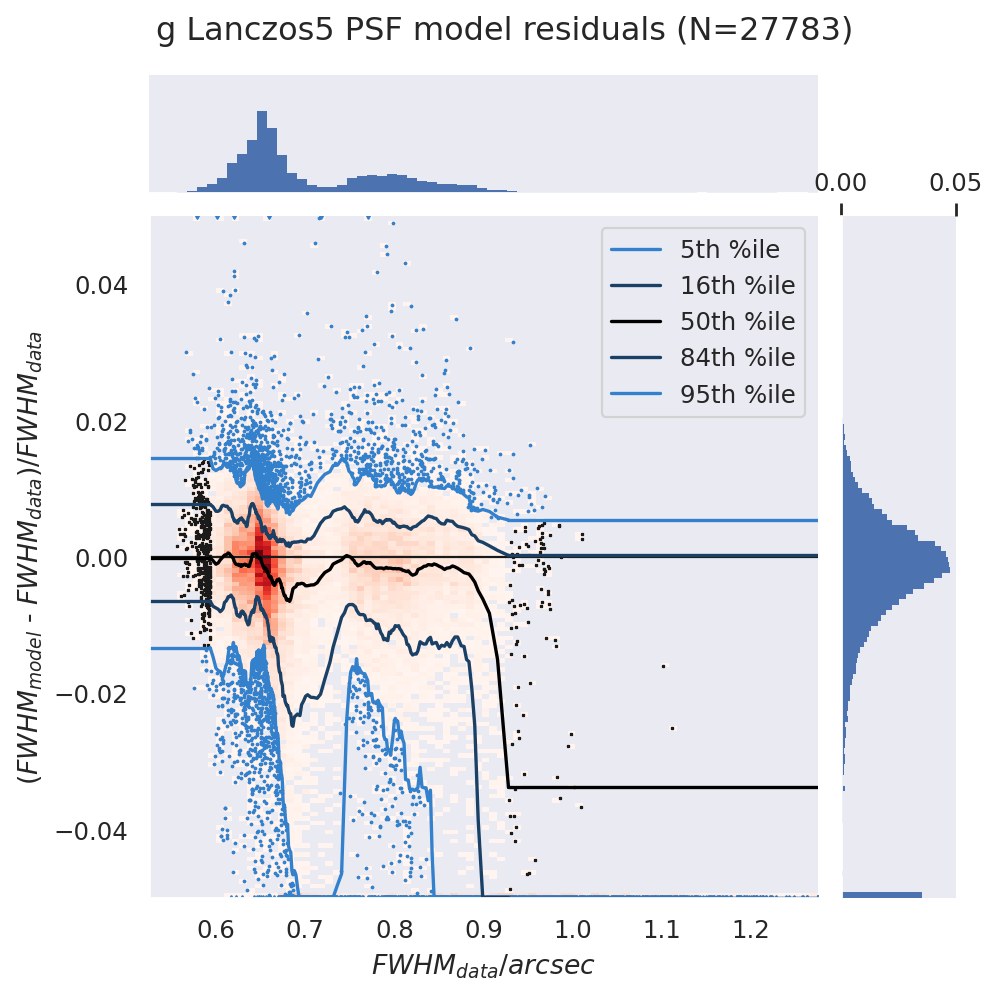

r Lanczos5 PSF model residuals (N=39445)


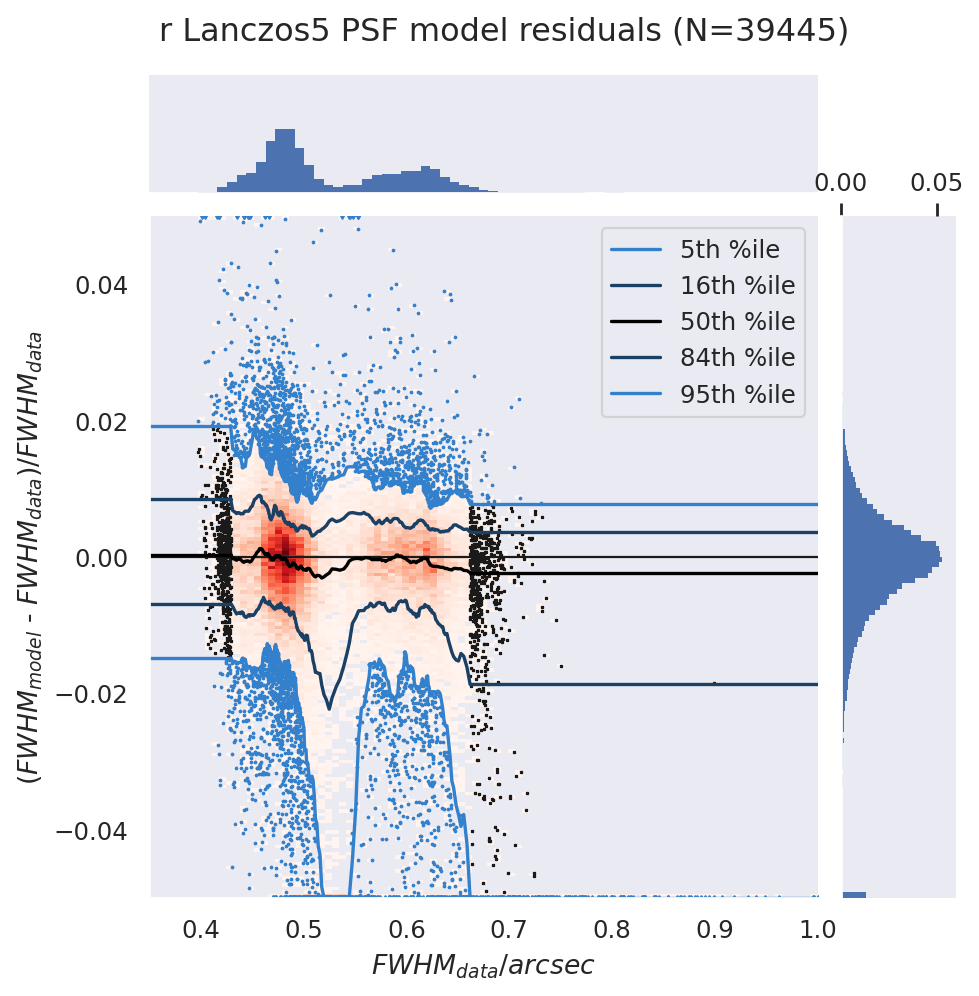

i Lanczos5 PSF model residuals (N=33561)


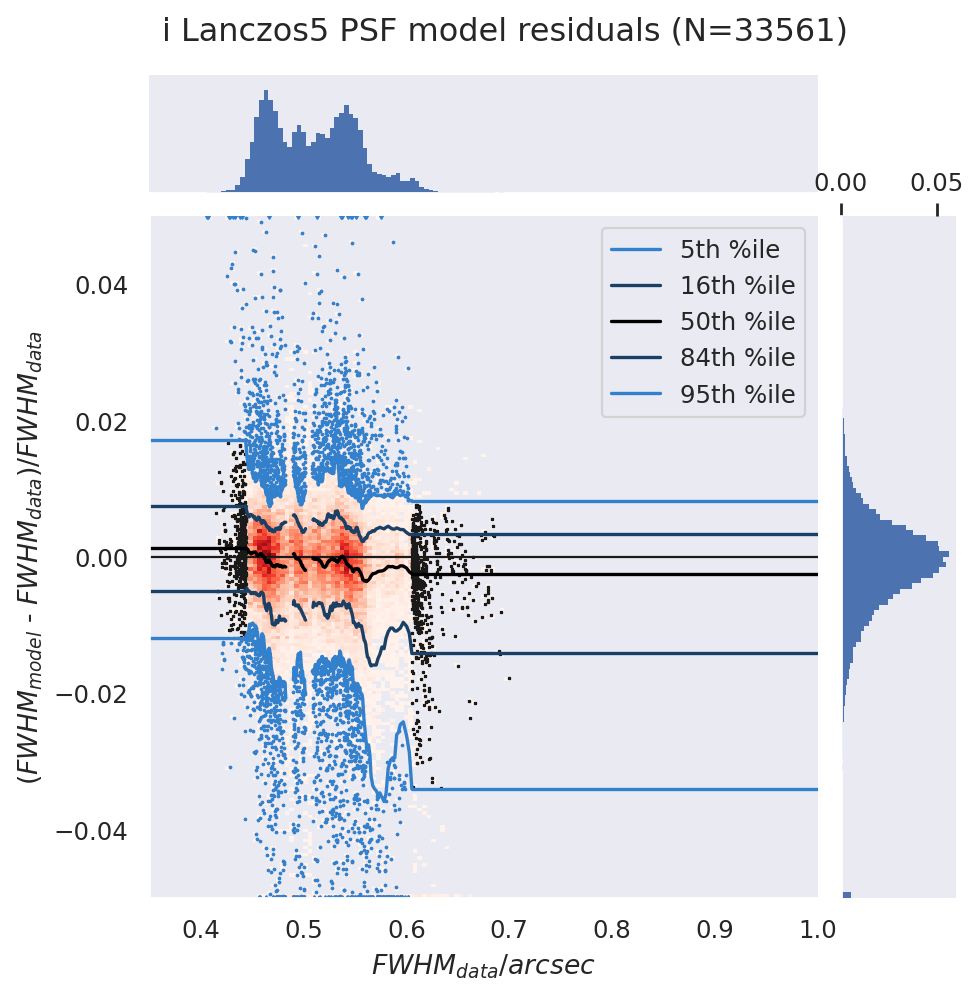

g Lanczos5, 0.556 <= FWHM <= 0.645, N=6945


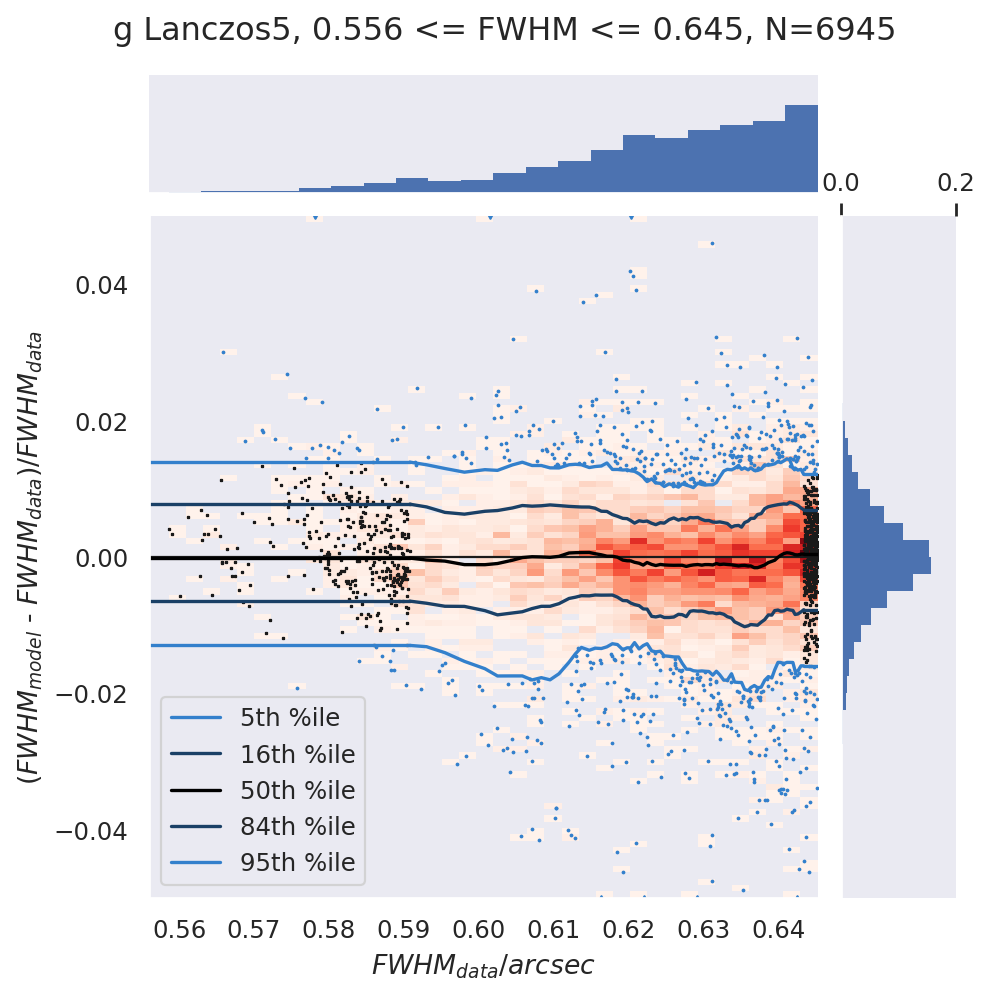

g Lanczos5, 0.645 <= FWHM <= 0.667, N=6944


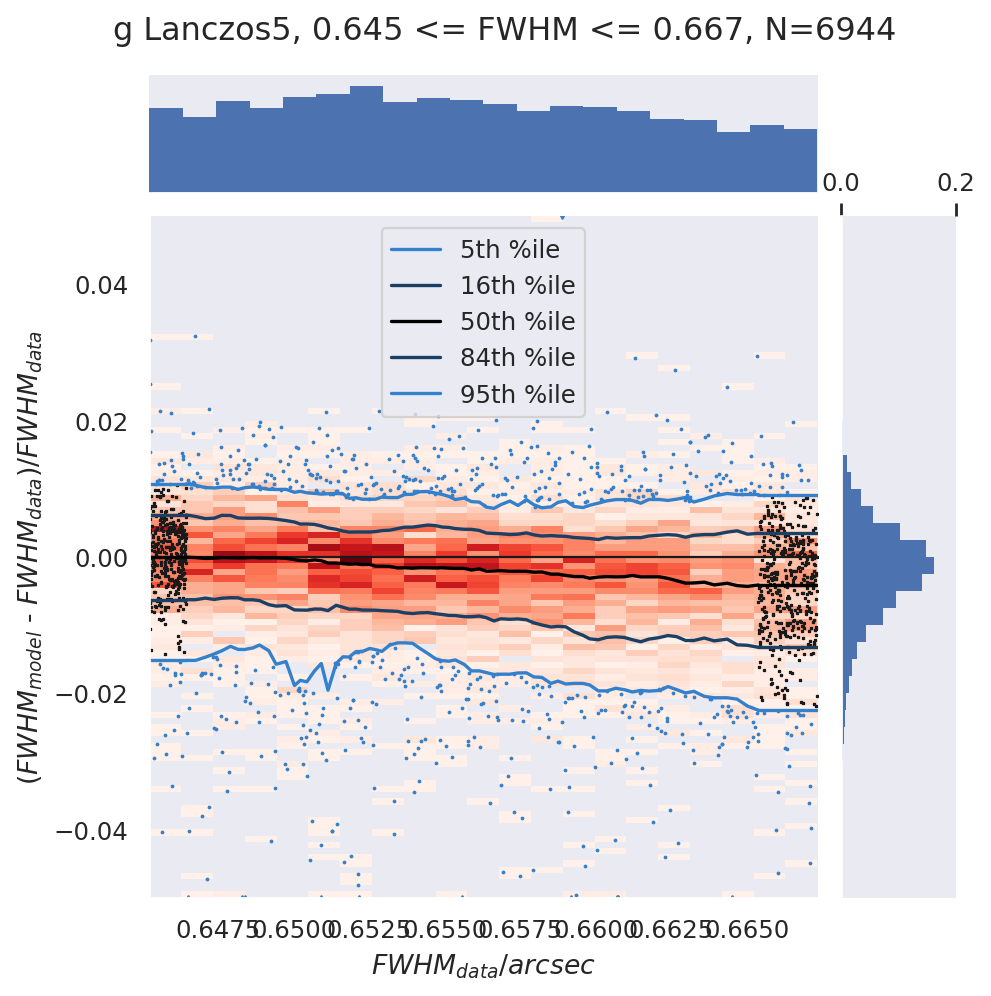

g Lanczos5, 0.667 <= FWHM <= 0.779, N=6944


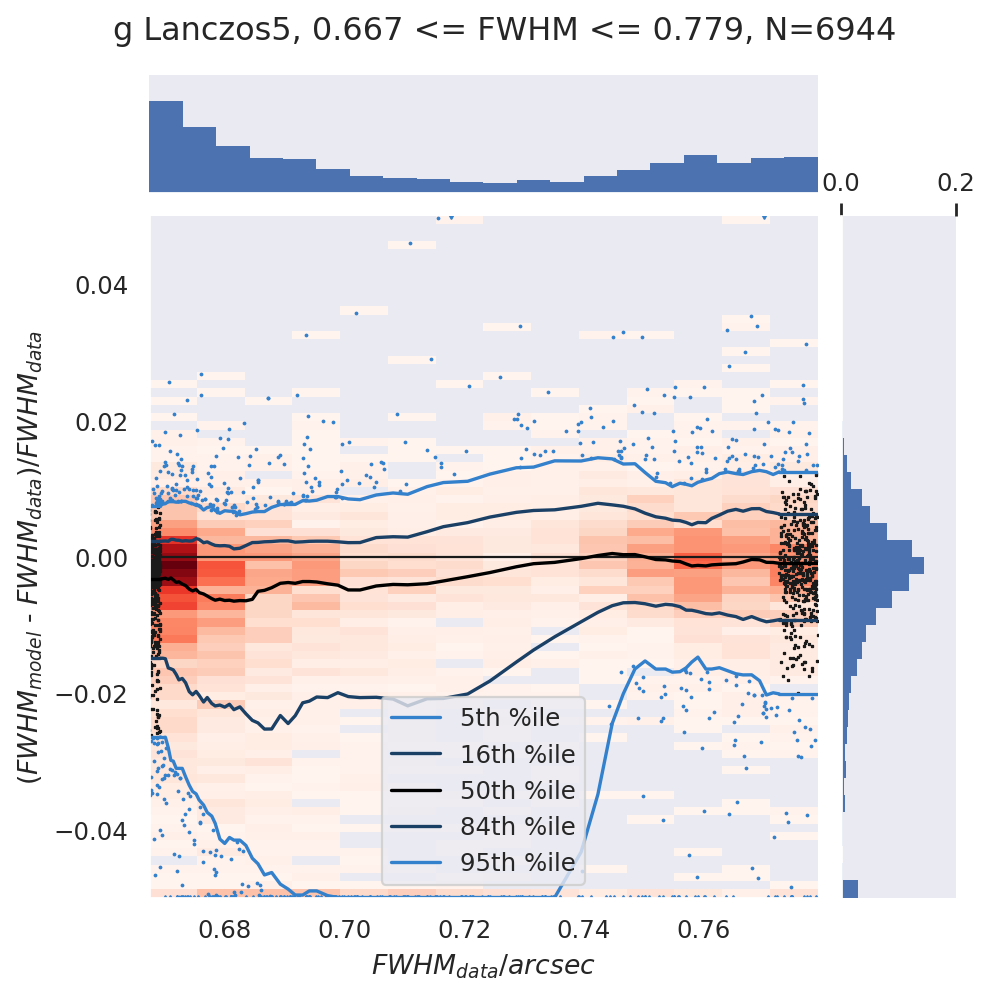

g Lanczos5, 0.779 <= FWHM <= 1.681, N=6945


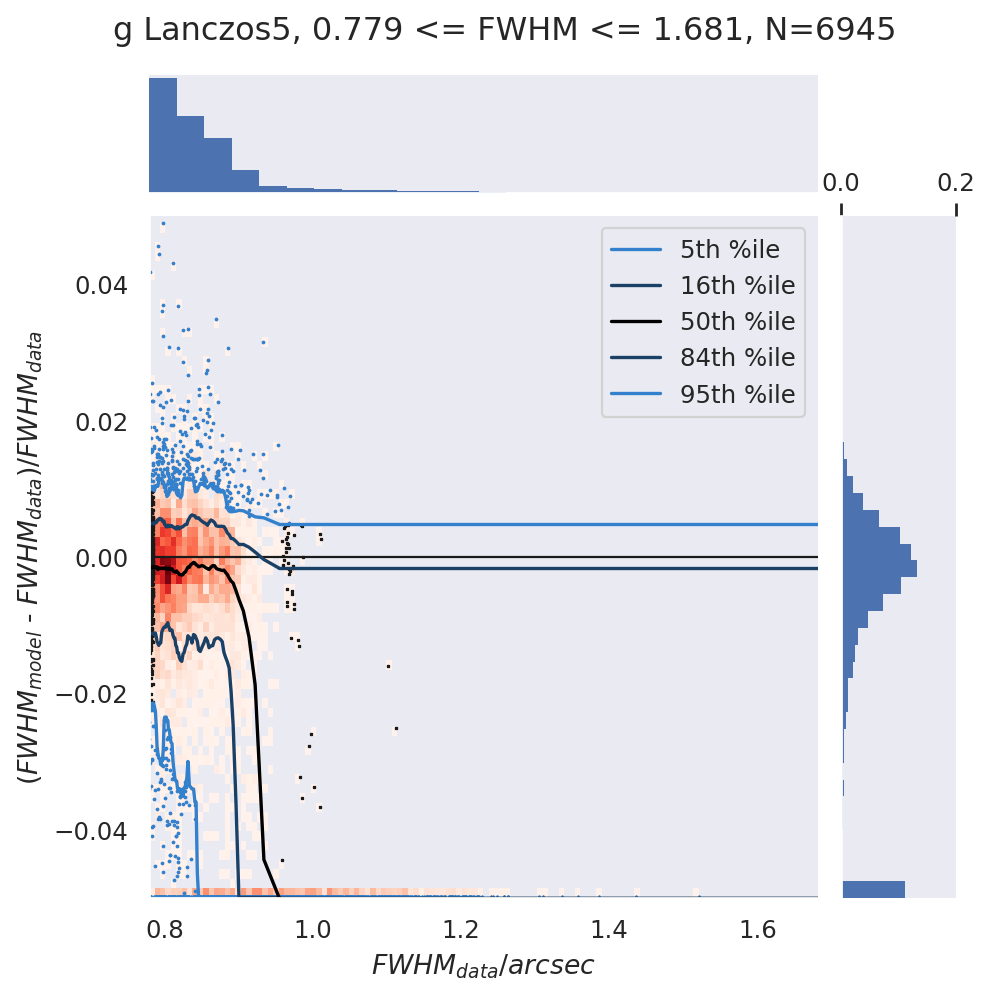

r Lanczos5, 0.397 <= FWHM <= 0.474, N=9860


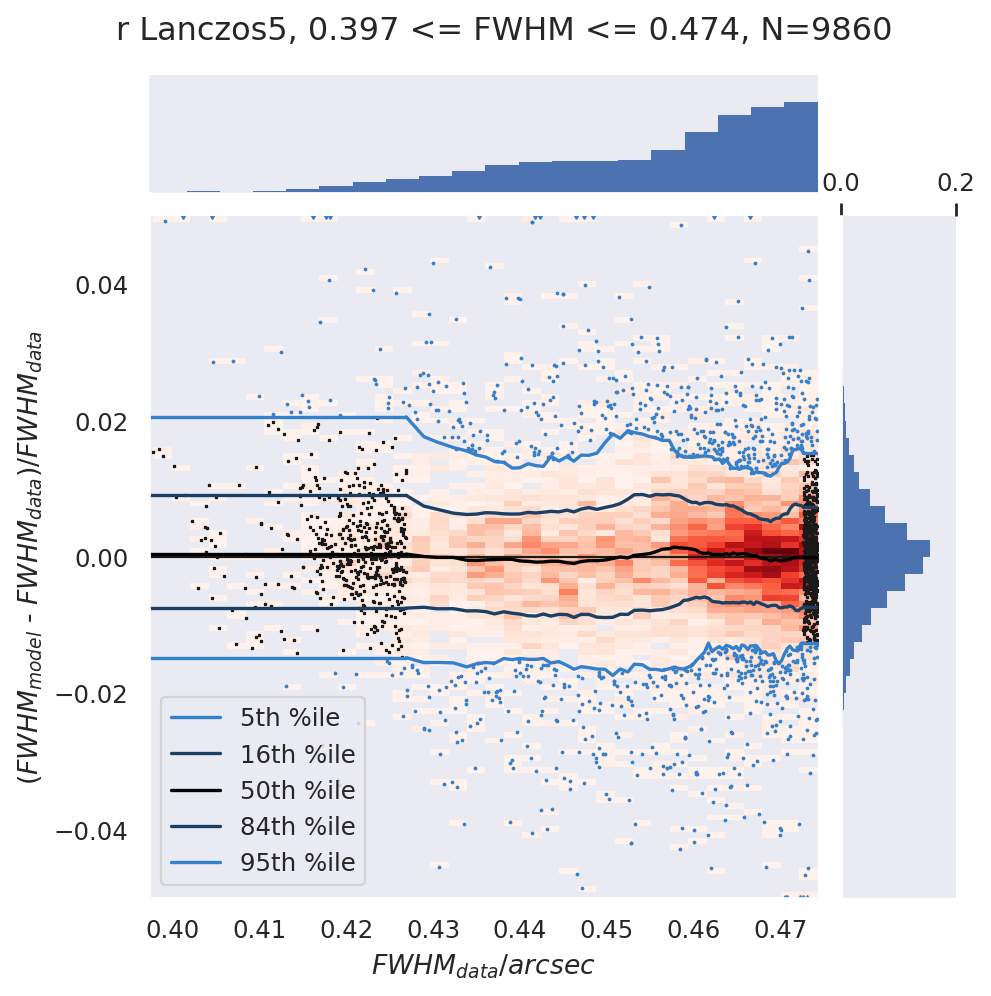

r Lanczos5, 0.474 <= FWHM <= 0.497, N=9860


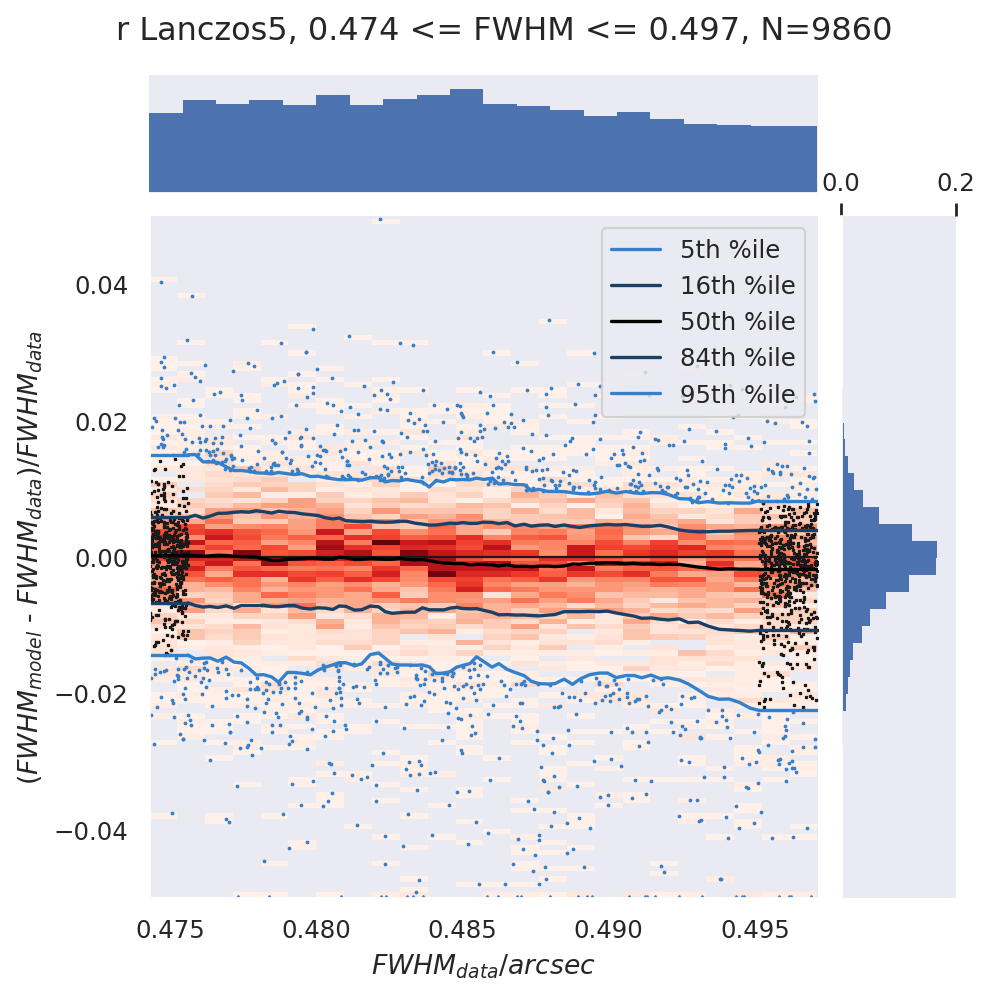

r Lanczos5, 0.497 <= FWHM <= 0.592, N=9860


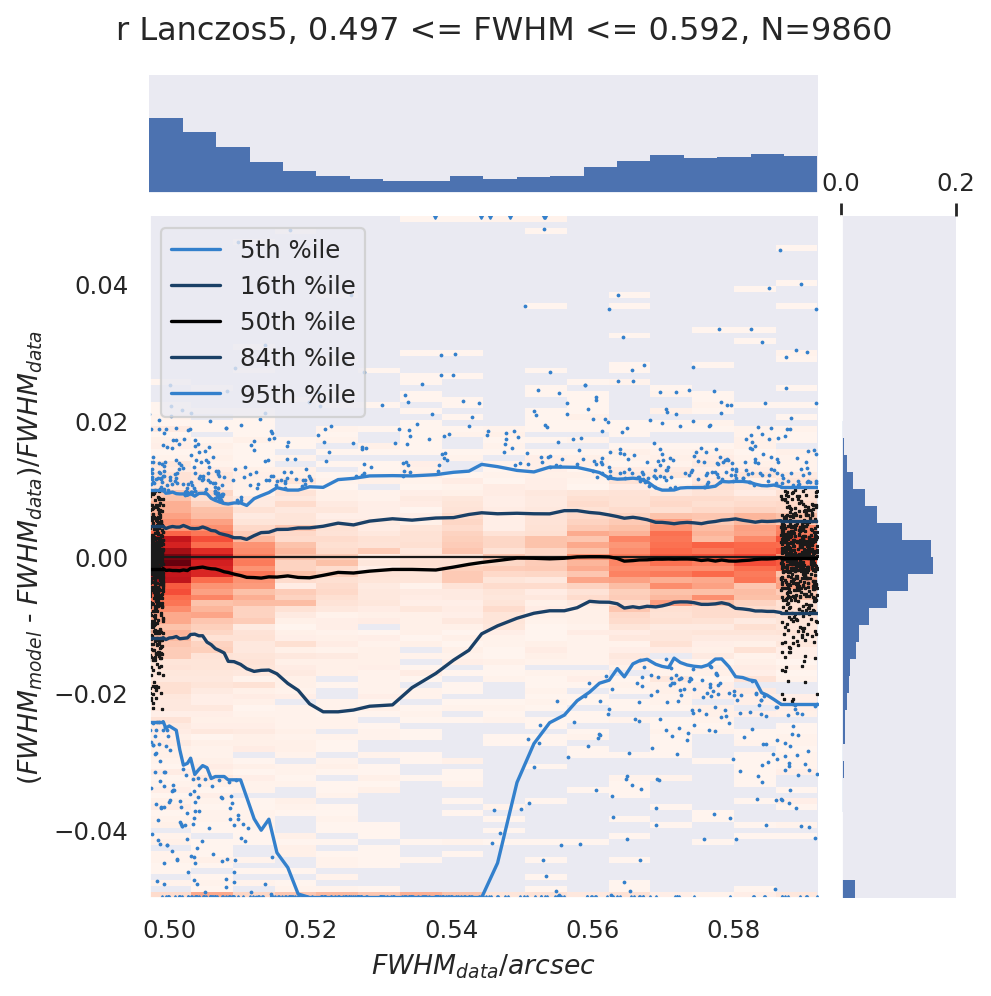

r Lanczos5, 0.592 <= FWHM <= 1.084, N=9860


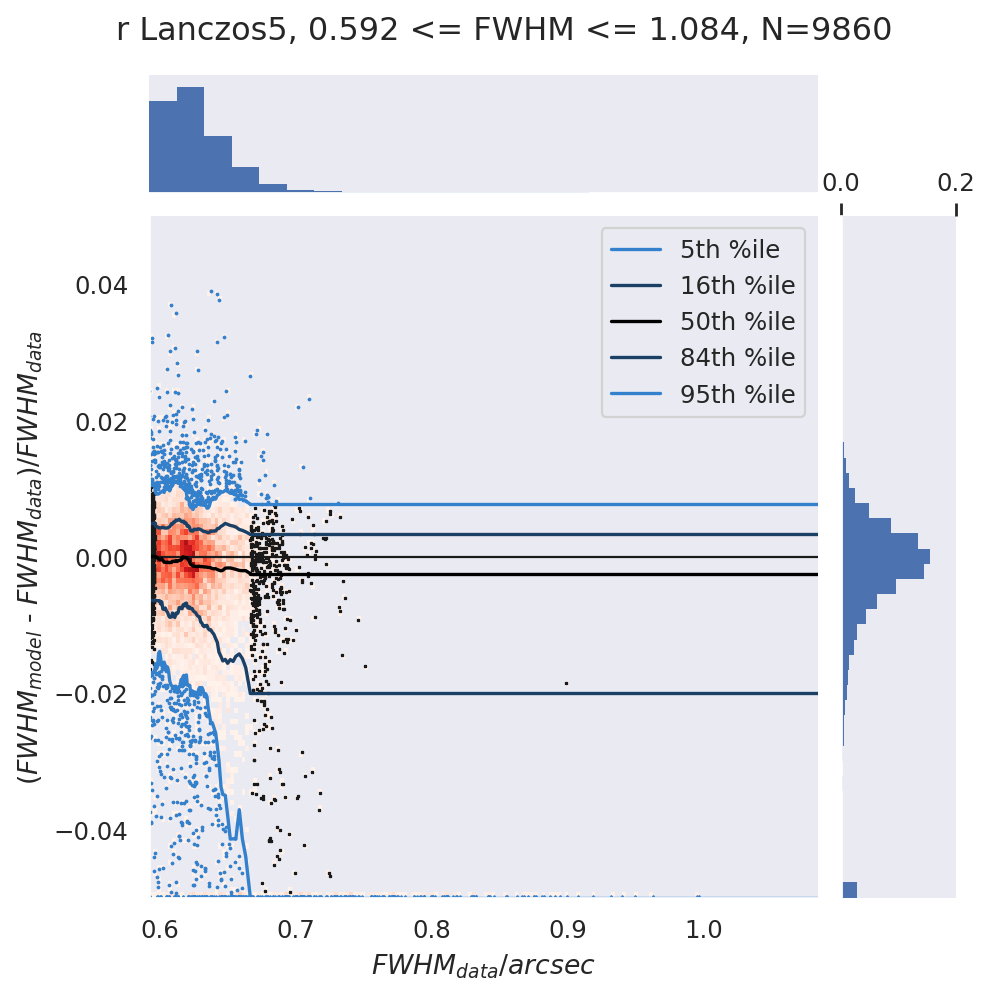

i Lanczos5, 0.406 <= FWHM <= 0.471, N=8388


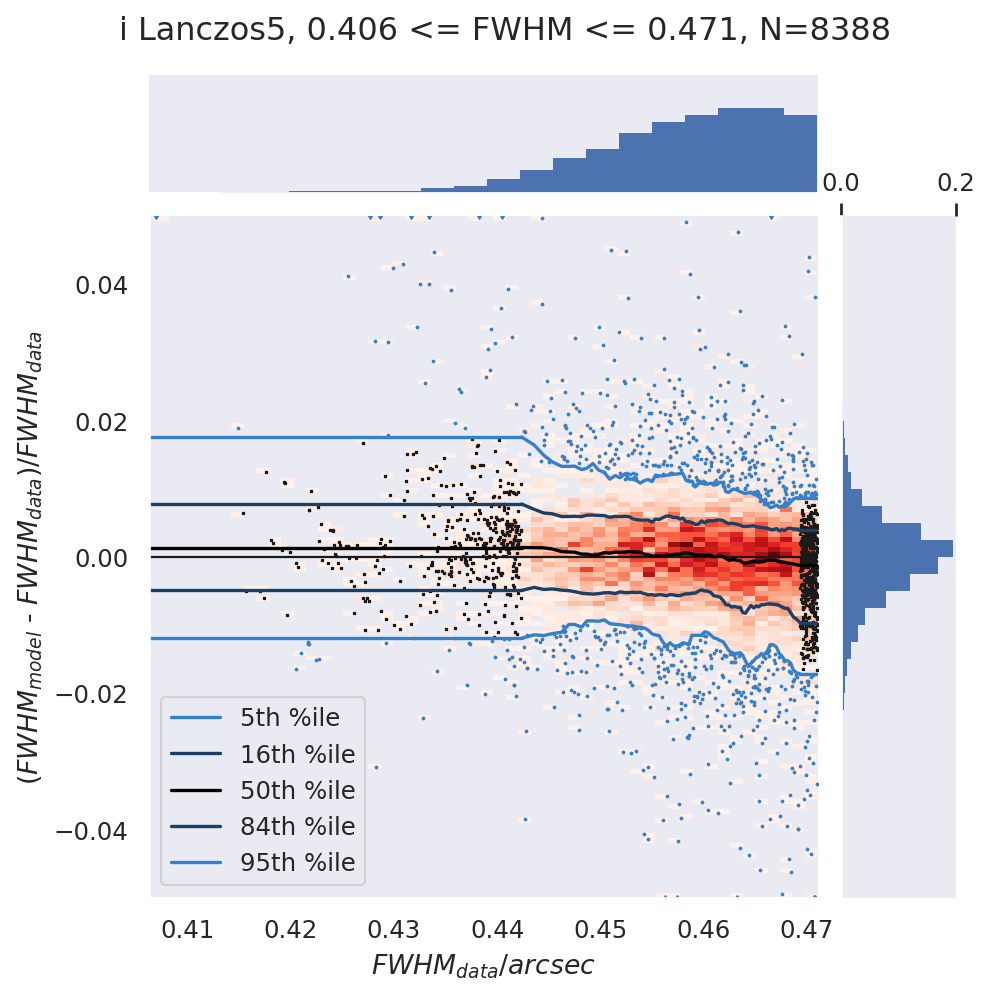

i Lanczos5, 0.471 <= FWHM <= 0.509, N=8388


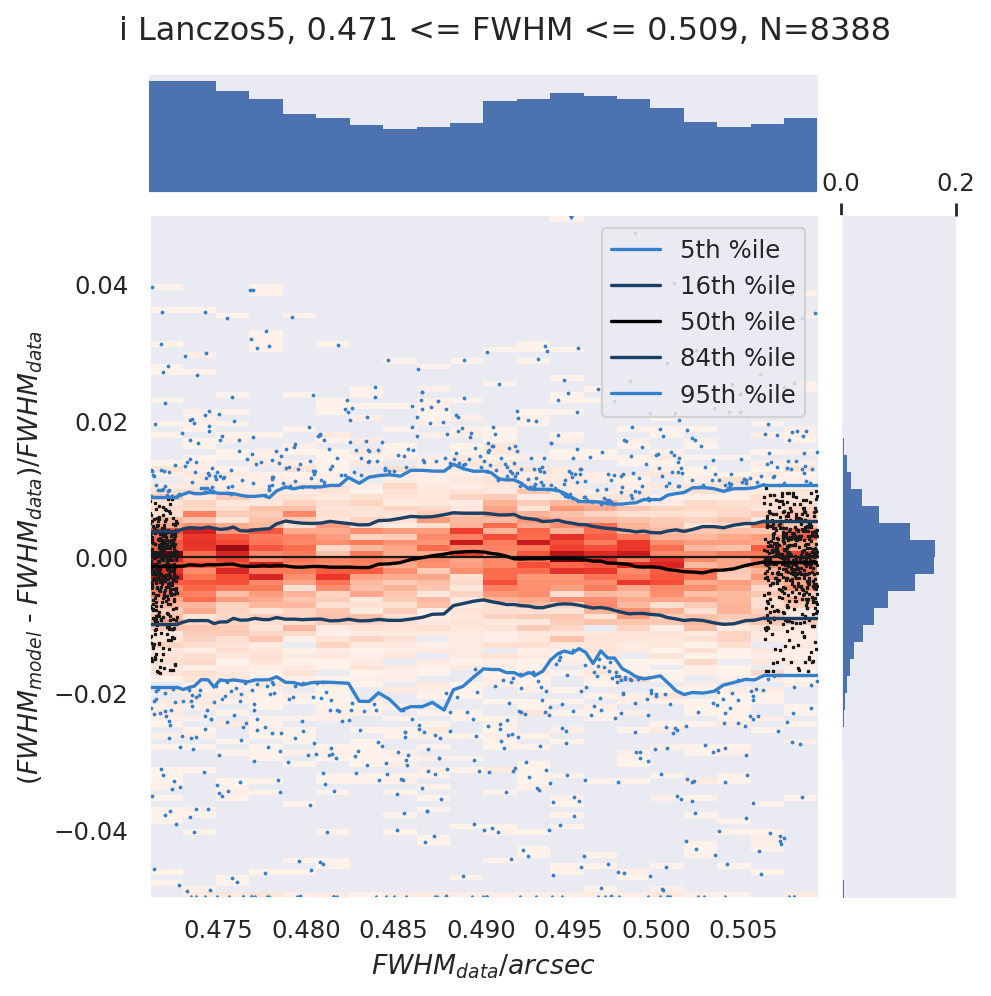

i Lanczos5, 0.509 <= FWHM <= 0.543, N=8387


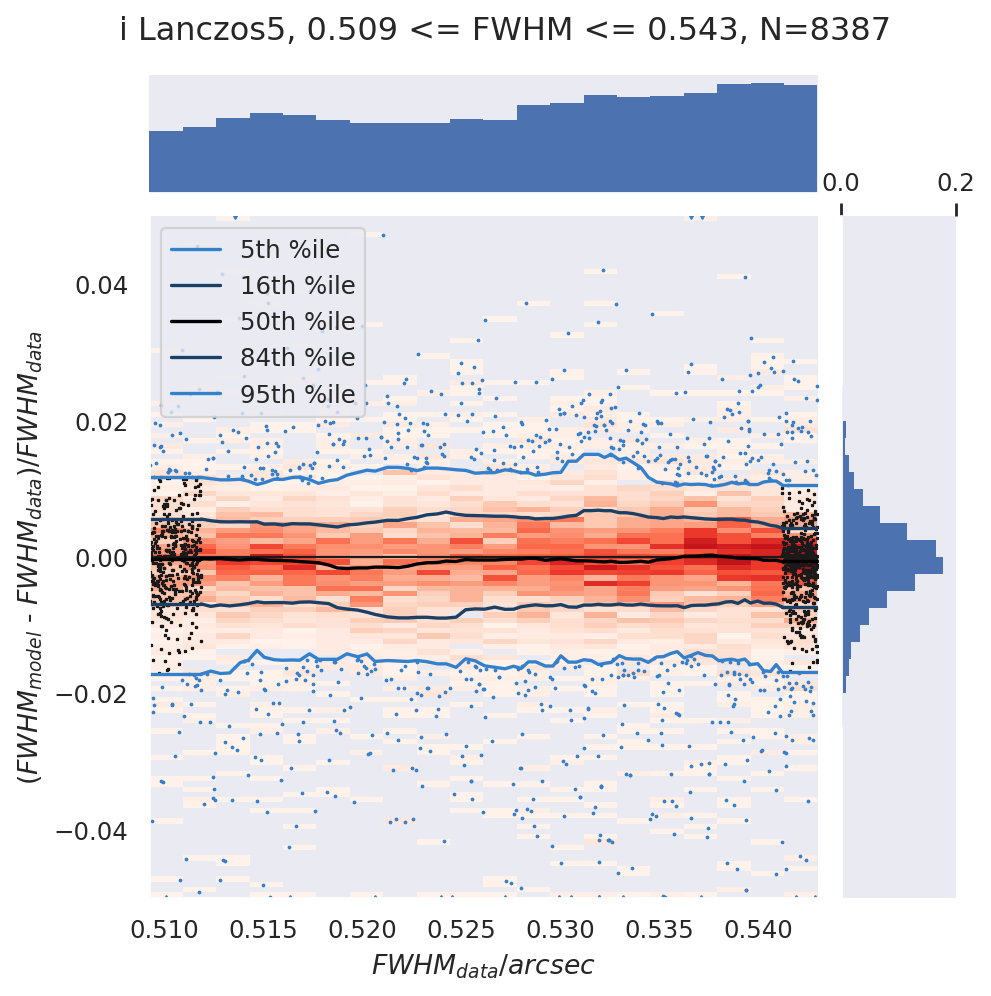

i Lanczos5, 0.543 <= FWHM <= 0.700, N=8388


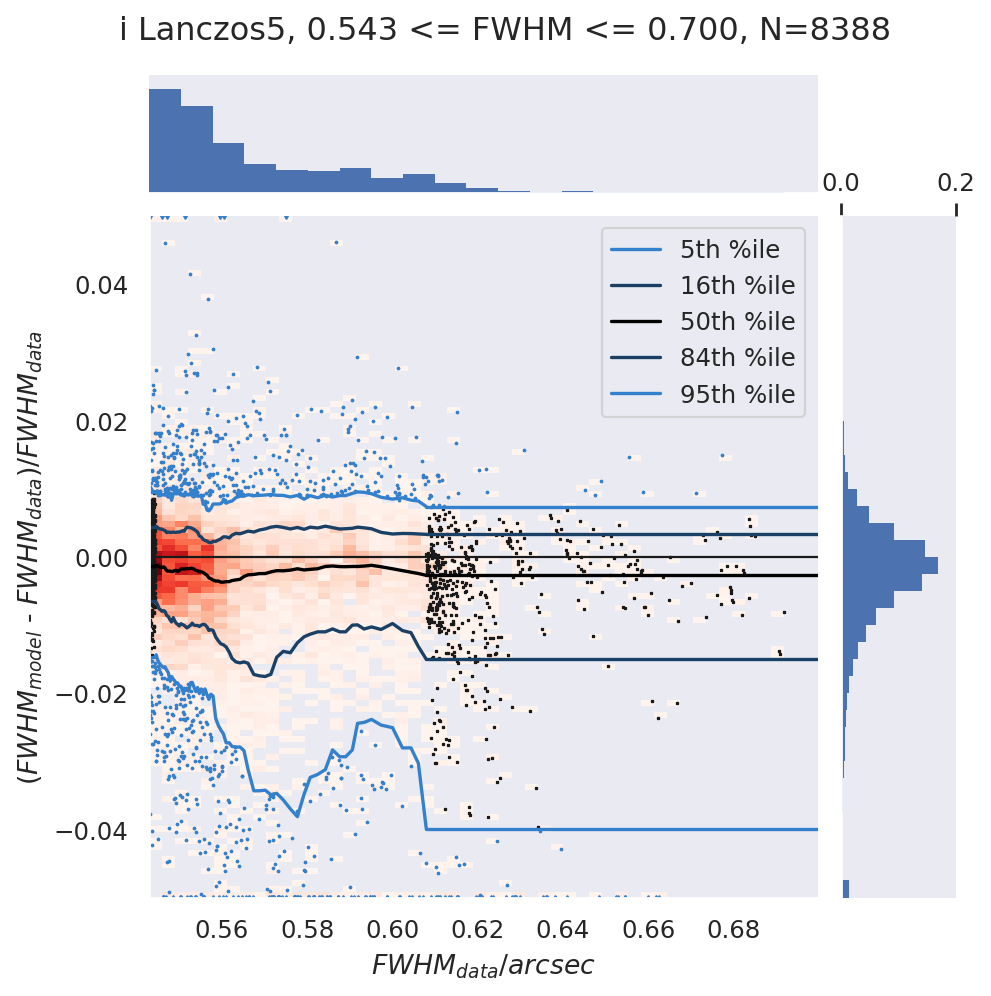

In [6]:
# Plot
kwargs_plotjoint = dict(
    nbinspan = 8,
    densityplot=sns.histplot,
    cmap='Reds',
    limy=limsfrac,
    scatterleft=True,
    scatterright=True,
)
plot_patch = False
labelflux = 'log10(instFluxPsf)'
labelsizeresid = r'($FWHM_{model}$ - $FWHM_{data}$)/$FWHM_{data}$'
labelsize = r'$FWHM_{data}/arcsec$'

for dataplot, typeofdata in ((data, 'Lanczos5'),):
    for band, limx in limxs.items():
        datum = dataplot[band]
        limx = limxs[band]
        x = np.clip(datum['starSize'], limx[0], limx[1])
        sizefrac = (datum['modelSize'] - datum['starSize'])/datum['starSize']
        title=f'{band} {typeofdata} PSF model residuals (N={len(x)})'
        print(title)
        plotjoint_running_percentiles(
            x, sizefrac, limx=limx, ndivisions=32,
            labelx=labelsize, labely=labelsizeresid, title=title,
            **kwargs_plotjoint
        )
        plt.show()
        
for dataplot, typeofdata in ((data, 'Lanczos5'),):
    for band, limx in limxs.items():
        datum = dataplot[band]
        sizefrac = (datum['modelSize'] - datum['starSize'])/datum['starSize']
        condsizefrac = np.isfinite(sizefrac) & np.isfinite(datum['fluxPsf']) & (datum['starSize']<2)
        sizebins = np.sort(datum['starSize'][condsizefrac])[
            np.asarray(np.round(np.linspace(0, np.sum(condsizefrac)-1, num=4+1)), dtype=int)
        ]
        for idx in range(len(sizebins) - 1):
            sizemin, sizemax = sizebins[idx:idx+2]
            cond = condsizefrac & (datum['starSize'] > sizemin) & (datum['starSize'] < sizemax)
            numpoints = np.sum(cond)
            title = f'{band} {typeofdata}, {sizemin:.3f} <= FWHM <= {sizemax:.3f}, N={numpoints}'
            if numpoints >= 100:    
                print(title)
                x = datum['starSize'][cond]
                y = sizefrac[cond]
                plotjoint_running_percentiles(
                    x, y, limx=(sizemin, sizemax), ndivisions=10,
                    labelx=labelsize, labely=labelsizeresid, title=title,
                    **kwargs_plotjoint
                )
                plt.show()
        if plot_patch:
            # TODO: Make sensible plots per patch
            for patch in patches:
                cond = (datum['file'] == patch) & condsizefrac
                grid = sns.jointplot(
                    np.log10(datum['fluxPsf'][cond]), sizefrac[cond], ylim=[-0.1, 0.1],
                    stat_func=None, size=4, s=1, marginal_kws={'bins': 30},
                )
                grid.fig.suptitle(band)